In [1]:
import openeo
from openeo.rest.datacube import PGNode, THIS
from openeo.processes import *
import math

In [7]:
backend = "openeo.cloud"
conn = openeo.connect(backend)
conn = conn.authenticate_oidc()

Authenticated using refresh token.


In [8]:
def fit_process(bbox):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    temporal_extent = ["2016-09-01", "2018-09-01"] 
    collection      = 'SENTINEL1_SIG0_20M'  
    bands           = ["VV", "VH"]
    properties = {"sat:orbit_state": lambda x: eq(x, "ascending")}

    sig0_data = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent, properties=properties)

    def fitFunction(x, parameters):
        t = 2 * math.pi / 31557600 * x
        return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)

    curve_fitting = sig0_data.fit_curve(
        parameters=[1,1,1],
        dimension="time",
        function=fitFunction
    )
    fitted_parameters = curve_fitting.save_result(format="NetCDF")
    return fitted_parameters

In [9]:
bbox = [11.3, 46.3, 11.45, 46.35]

In [10]:
data = fit_process(bbox = bbox)

job = data.create_job(title = "UC6-1")
job_id = job.job_id
job.start_job()

/home/vhutter/notebooks/.venv/lib/python3.10/site-packages/openeo/rest/connection.py:1176: UserWarning: SENTINEL1_SIG0_20M property filtering with properties that are undefined in the collection metadata (summaries): sat:orbit_state.
  return DataCube.load_collection(


<BatchJob job_id='8a826758-0ae1-46db-bb54-e51d590f26db'>

In [11]:
job

<BatchJob job_id='8a826758-0ae1-46db-bb54-e51d590f26db'>

In [12]:
def change_detection_process(job_id, bbox):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    temporal_extent = ["2016-09-01", "2018-09-01"] 
    collection      = 'SENTINEL1_SIG0_20M'  
    bands           = ["VV", "VH"]
    properties = {"sat:orbit_state": lambda x: eq(x, "ascending")}

    sig0_data = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent, properties=properties)
    
    def fitFunction(x, parameters):
        t = 2 * math.pi / 31557600 * x
        return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)
    
    
    curve_fitting_loaded = conn.load_stac(url = f'{backend}/jobs/{job_id}/results')
    
    temporal_labels =  sig0_data.dimension_labels('time')
    curve_prediction = curve_fitting_loaded.predict_curve(parameters= curve_fitting_loaded, dimension= 'time', function= fitFunction, labels= temporal_labels)
    
    merged_cubes = sig0_data.merge_cubes(curve_prediction,overlap_resolver=subtract)
    
    mse = merged_cubes.band("VV")**2 + merged_cubes.band("VH")**2 
    rmse = (mse/len(bands))**0.5
    
    rmse_std = rmse.reduce_dimension(dimension='time',reducer=sd)
    
    rmse_std_netcdf = rmse_std.save_result(format="NetCDF")
    return rmse_std_netcdf

In [13]:
rmse_std_netcdf = change_detection_process(job_id, bbox)
job = rmse_std_netcdf.create_job(title = "UC6-2")
jobIdPrediction = job.job_id
job.start_job()

<BatchJob job_id='51dd0353-1b61-462c-b6dd-bc61635b8322'>

In [14]:
job

<BatchJob job_id='51dd0353-1b61-462c-b6dd-bc61635b8322'>

In [15]:
def change_detection_prediction_process(job_id, bbox, job_id_change_detection):
    spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
    temporal_extent = ["2018-10-01", "2019-03-01"] 
    collection      = 'SENTINEL1_SIG0_20M'  
    bands           = ["VV", "VH"]
    properties = {"sat:orbit_state": lambda x: eq(x, "ascending")}

    sig0_data = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent, properties=properties)
    
    def fitFunction(x, parameters):
        t = 2 * math.pi / 31557600 * x
        return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)

    curve_fitting_loaded = conn.load_stac(url = f'{backend}/jobs/{job_id}/results')
    
    temporal_labels =  sig0_data.dimension_labels('time')
    curve_prediction_test = curve_fitting_loaded.predict_curve(parameters= curve_fitting_loaded, dimension= 'time', function= fitFunction, labels= temporal_labels)

    merged_cubes_test = sig0_data.merge_cubes(curve_prediction_test,overlap_resolver=subtract)
    mse = merged_cubes_test.band("VV")**2 + merged_cubes_test.band("VH")**2 
    rmse = (mse/len(bands))**0.5
    
    
    training_std_loaded = conn.load_stac(url = f'{backend}/jobs/{job_id_change_detection}/results')
    
    alarm_threshhold = training_std_loaded.apply(lambda x: x * 3)
    alarm_cubes = rmse.merge_cubes(alarm_threshhold,overlap_resolver=gt)
    alarm_cubes_netcdf = alarm_cubes.save_result(format="NetCDF", options={"tile_grid":"time-series"})
    
    return alarm_cubes_netcdf

In [16]:
alarm_cubes_netcdf = change_detection_prediction_process(job_id, bbox, jobIdPrediction)

job = alarm_cubes_netcdf.create_job(title = "UC6-3")
jobIdAlarms = job.job_id
job.start_job()

<BatchJob job_id='275a02f4-603e-463e-90c5-e829f7a8d59f'>

In [17]:
job

<BatchJob job_id='275a02f4-603e-463e-90c5-e829f7a8d59f'>

In [18]:
results = job.get_results()
metadata = results.get_metadata()
results.download_files("./uc6_sig0/")

[PosixPath('uc6_sig0/TimeSeries_E4861310N1465910_20181004T170656.nc'),
 PosixPath('uc6_sig0/job-results.json')]

Check if data is as expected - should contain True and False values.

In [19]:
import xarray as xr

sig0_p = xr.open_dataset("uc6_sig0/TimeSeries_E4861310N1465910_20181004T170656.nc")


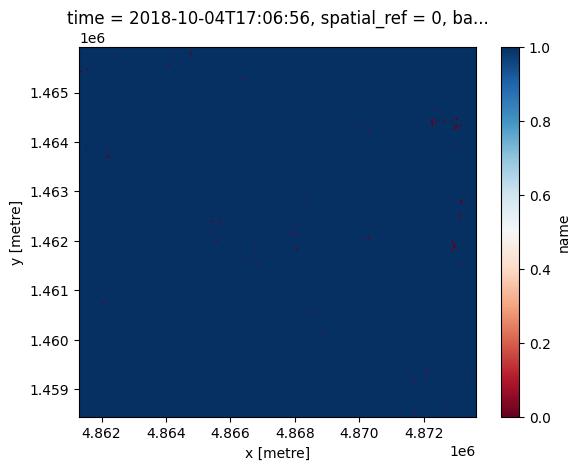

In [26]:
sig0_p.name.isel(time=0).plot(cmap="RdBu")